TensorFlow 2 Object Detection API: TensorFlow provides tools and libraries for object detection tasks. The TensorFlow Model Garden contains various pre-trained models and scripts for training new models.

In [1]:
#removing if there is an existing models directory
!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 4107, done.
remote: Counting objects: 100% (4107/4107), done.
remote: Compressing objects: 100% (3108/3108), done.
remote: Total 4107 (delta 1188), reused 2033 (delta 937), pack-reused 0
Receiving objects: 100% (4107/4107), 45.35 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (1188/1188), done.
Updating files: 100% (3716/3716), done.


TensorFlow Model Garden: This repository contains various machine learning models, including tools for object detection.

Commands Breakdown:

sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py: Uses sed (stream editor) to replace the version requirement for tf-models-official in setup.py.
protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .: Compiles protocol buffers, copies setup file, and installs required packages for TensorFlow Object Detection API.

In [2]:
# For compatibility. Pin tf-models-official version so it will use Tensorflow 2.15.
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

# Compile the Object Detection API protocol buffers and install the necessary packages
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 19.2 MB/s e

In [3]:
import os
import random
import zipfile
import io

import matplotlib
import matplotlib.pyplot as plt


import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf



**glob**: Helps find files and directories whose names match a specified pattern using Unix shell-style wildcards.

**imageio**: Library for reading and writing a wide range of image data, including animated images.

**six.BytesIO**: A utility for creating in-memory binary streams (BytesIO objects).

**IPython.display** : Provides a way to display rich content in the Jupyter Notebook.

**PIL.Image**: Python Imaging Library (PIL) provides capabilities for opening, manipulating, and saving many different image file formats.



In [4]:
#module for building the detection model
from object_detection.builders import model_builder

# module for utilities in Colab
from object_detection.utils import colab_utils

# module for visualization. use the alias `viz_utils`
from object_detection.utils import visualization_utils as viz_utils

# import the label map utility module
from object_detection.utils import label_map_util

#module for reading and updating configuration files.
from object_detection.utils import config_util





Imports utilities from the TensorFlow Object Detection API

In [5]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """

    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """

    image_np_with_annotations = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)

    if image_name:
        plt.imsave(image_name, image_np_with_annotations)

    else:
        plt.imshow(image_np_with_annotations)


Link to drive for training dataset (https://drive.google.com/file/d/1BGaPAZyddE8HJBE0ubfjuYLmz97kgg-a/view?usp=sharing)

In [6]:
# delete an existing zip and training directory
!rm training_image.zip
!rm -rf ./training

# download the images, use gdown to download from Google Drive
!pip install gdown
#https://drive.google.com/file/d/1BGaPAZyddE8HJBE0ubfjuYLmz97kgg-a/view?usp=sharing
!gdown --id 1BGaPAZyddE8HJBE0ubfjuYLmz97kgg-a -O ./training-cars.zip # Replace with the actual file ID

# unzip to a local directory
local_zip = './training-cars.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

rm: cannot remove 'training_image.zip': No such file or directory
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BGaPAZyddE8HJBE0ubfjuYLmz97kgg-a
To: /content/training-cars.zip
100% 1.46M/1.46M [00:00<00:00, 100MB/s]


./training/car1.jfif
./training/car2.jfif
./training/car3.jfif
./training/car4.jfif
./training/car5.jfif
./training/car6.jfif


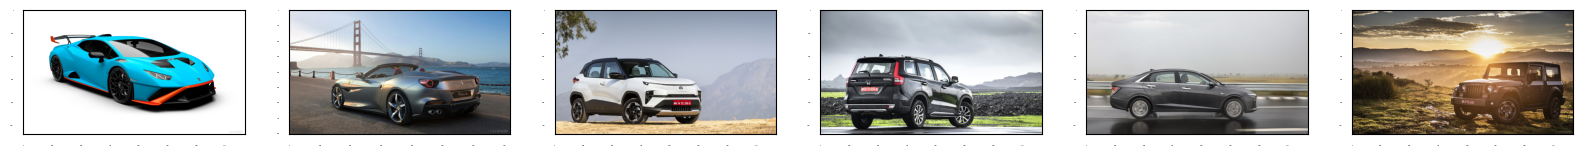

In [7]:
%matplotlib inline
# assigning the name (string) of the directory containing the training images
train_image_dir = './training'
# declare an empty list
train_images_np = []
# run a for loop for each image
for i in range(1, 7):

    # define the path (string) for each image
    image_path = os.path.join(train_image_dir, f'car{i}.jfif')
    print(image_path)

    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [20, 10]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 6, idx+1)
    plt.imshow(train_image_np)

plt.show()

In [8]:
# Define the list of ground truth boxes
gt_boxes = []
#draw your own ground truth boxes

# annotate the training images
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

Enclose the car(object) as possible such that not too much extra area is selected.

In [14]:
try:
  assert(len(gt_boxes) == 6), "Please click 'submit' if completed?"

except AssertionError as e:
  print(e)

# checks if there are boxes for all 6 images
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None), "Plese complete for all images. " \
                                  "please re-run cell and try again.\n" \
                                  "ground truth boxes."

    except AssertionError as e:
        print(e)
        break

Make sure that all the boxes are created.

In [15]:
# printig the selected co-ordinates of gt-box
#varies according to the selection
for gt_box in gt_boxes:
  print(gt_box)

[[0.16611979 0.1114624  0.84611979 0.8739624 ]]
[[0.42278646 0.18056098 0.93111979 0.87569987]]
[[0.36611979 0.05729574 0.94611979 0.6661499 ]]
[[0.34278646 0.09948324 0.96945313 0.70104574]]
[[0.45111979 0.1005249  0.91611979 0.7802124 ]]
[[0.41111979 0.44010824 0.92611979 0.9661499 ]]


In [16]:
# Assigning the car class ID
car_class_id = 1  # Assuming car class ID is 1

# Define a dictionary describing the car class
category_index = {1: {'id': 1, 'name': 'car'}}

# selecting the number of classes to detect
num_classes = 1  # Since there's only one class, which is 'car'

print(category_index[car_class_id])#references the category index

{'id': 1, 'name': 'car'}


Now lets convert images and their associated ground truth bounding boxes from NumPy arrays to TensorFlow tensors. It also ensures that ground truth classes are properly indexed and one-hot encoded according to the specified label_id_offset. This preprocessing step is crucial for feeding data into TensorFlow models efficiently.

In [17]:
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):

    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))

    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)

    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))


print('Done pre-processing data.')

Done pre-processing data.


Now lets assign the score for selected area to 1 i.e. 100% and plot them.

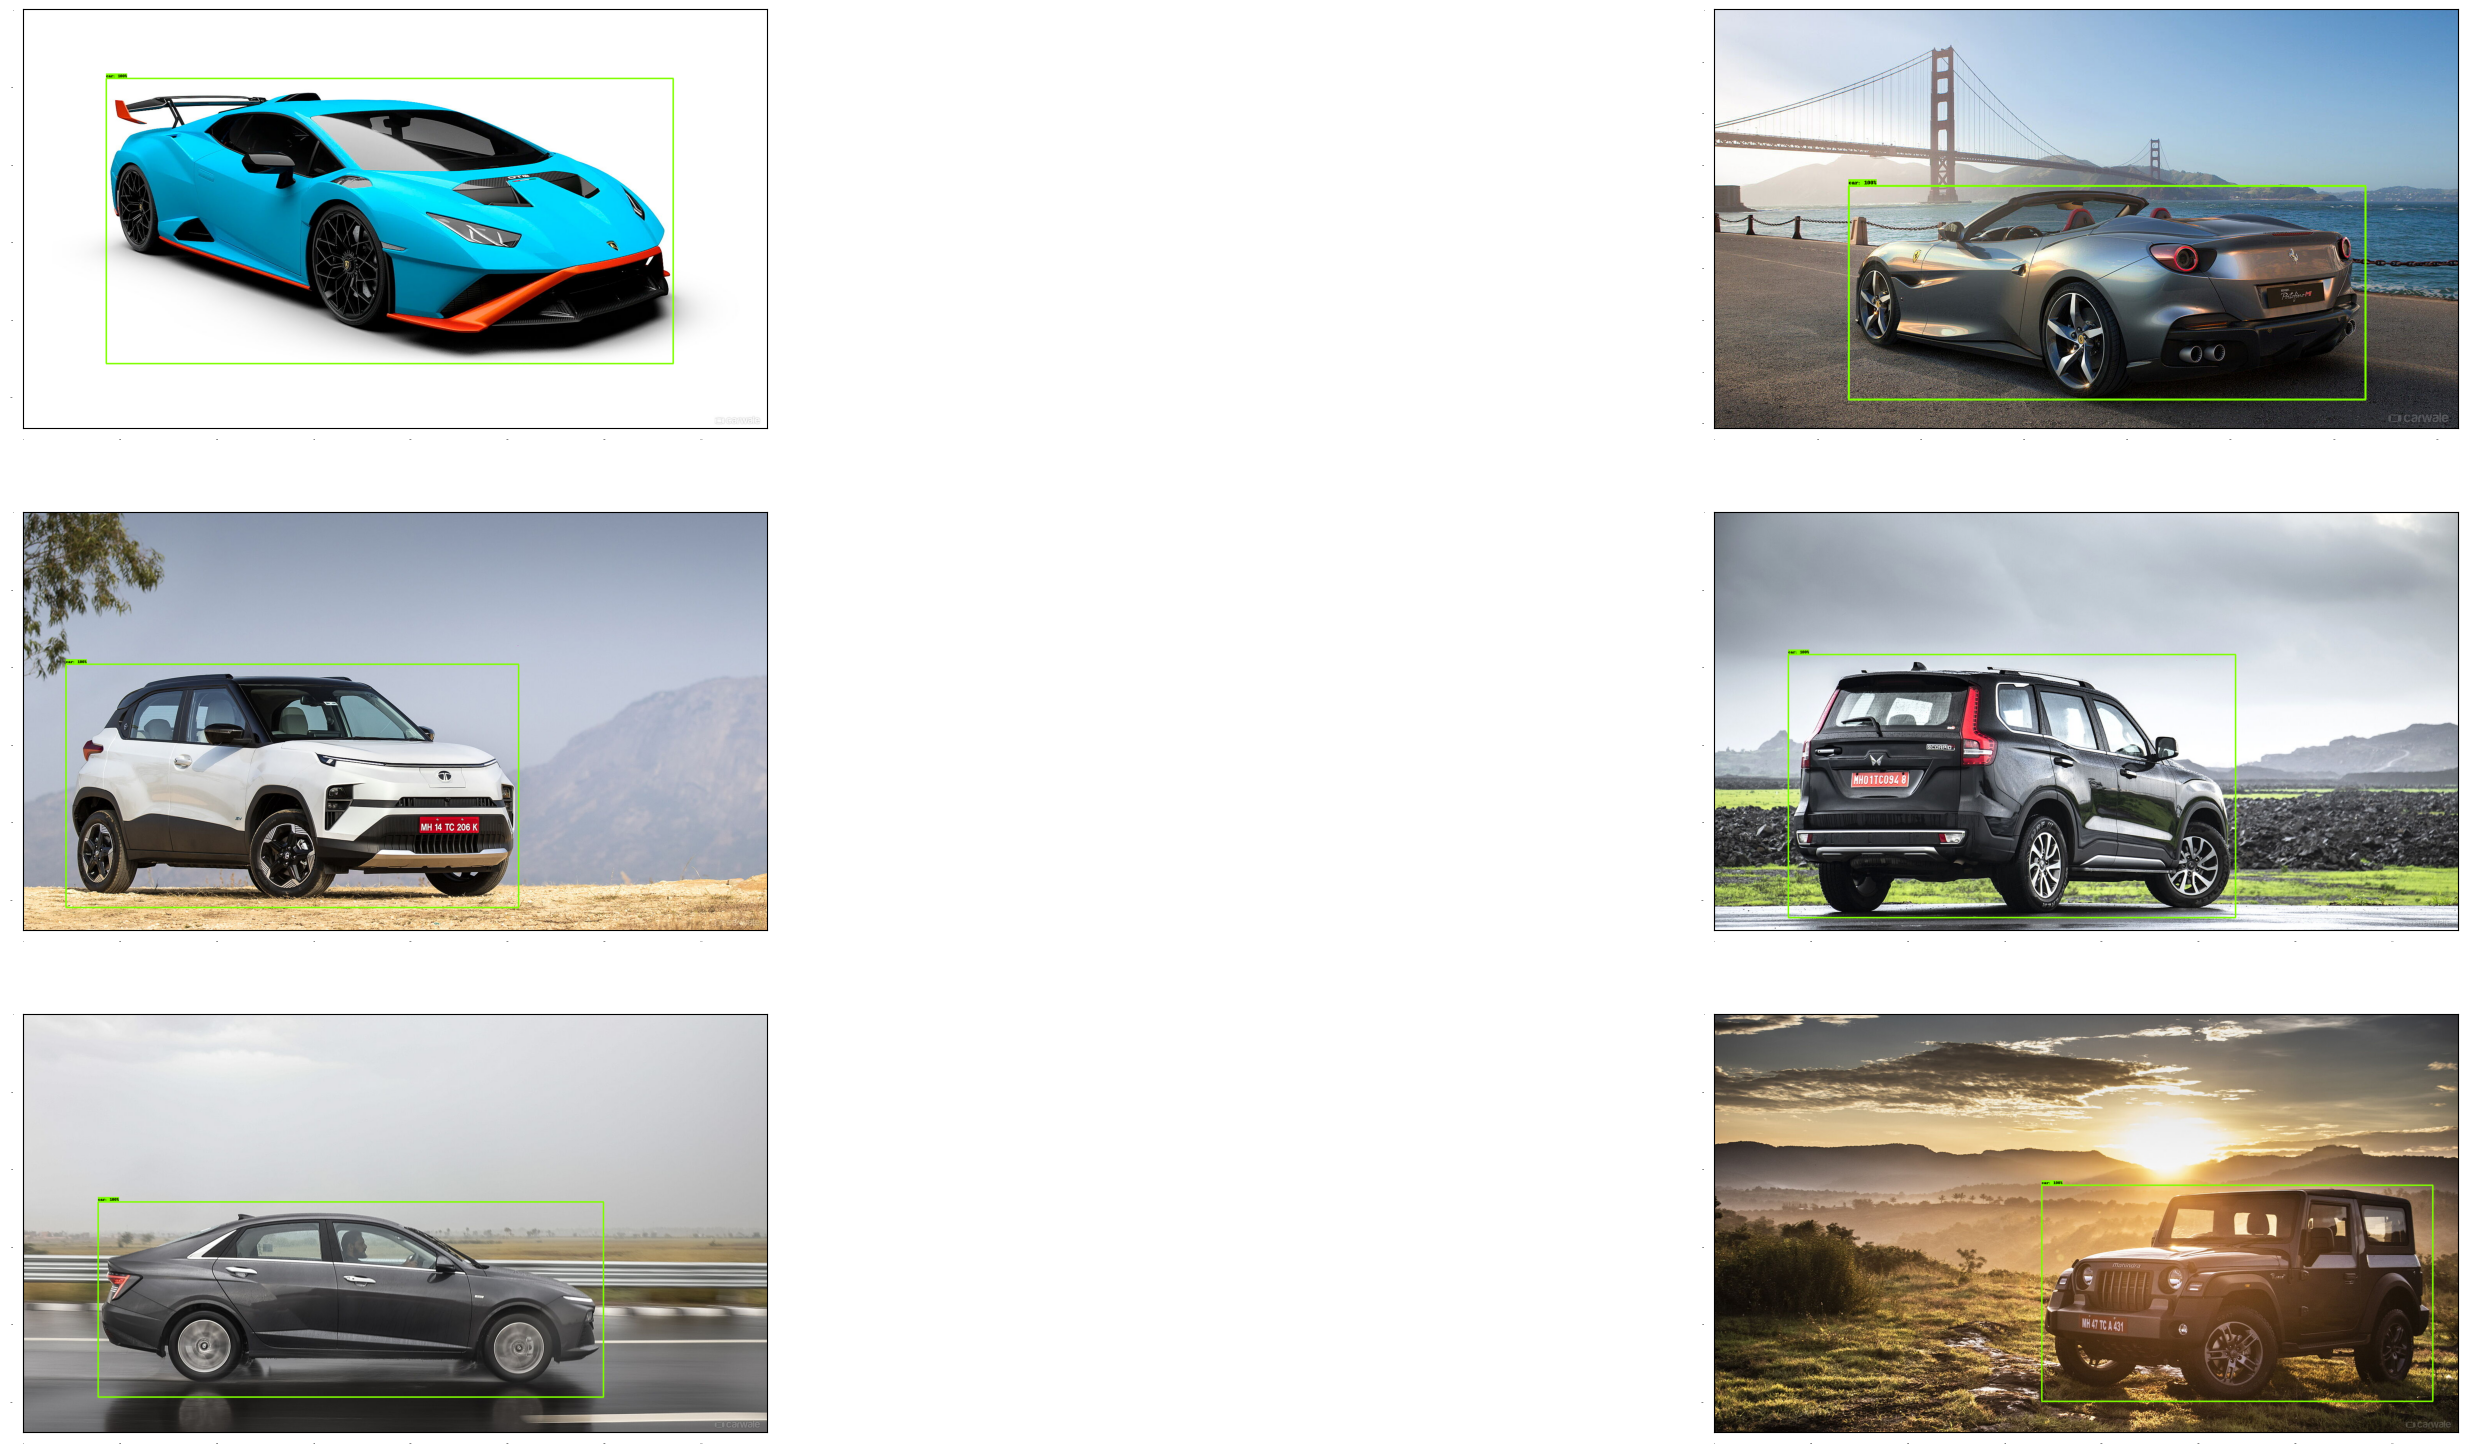

In [18]:
# assign boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(40, 25))

# using the `plot_detections()`  to draw the ground truth boxes
for idx in range(6):
    plt.subplot(4, 2, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

Now I  want to download a specific TensorFlow checkpoint for the SSD ResNet 50 version 1 model, untar (decompress) it, and then move it to a specific directory.

In [19]:
# Download the SSD Resnet 50 version 1, 640x640 checkpoint
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# copy the checkpoint to the test_data folder models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2024-06-21 09:59:47--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.199.207, 74.125.20.207, 108.177.98.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.199.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   167MB/s    in 1.4s    

2024-06-21 09:59:49 (167 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



Navigate to models/research/object_detection/configs/tf2. The folder has multiple .config files.
Look for the file corresponding to ssd resnet 50 version 1 640x640.
You can double-click the config file to view its contents. This may help you as you complete the next few code cells to configure your model.
Set the pipeline_config to a string that contains the full path to the resnet config file, in other words: models/research/.../... .config

In [20]:
tf.keras.backend.clear_session()

# path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = "/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config, config_override = None)
print(configs)

{'model': ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thr

Now lets go through the model configuration.

In [21]:
#object stored at the key 'model' of the configs dictionary
model_config = configs['model']
print(model_config)

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: f

This configuration defines a comprehensive setup for training and using an SSD model for object detection. It includes specifications for image resizing, feature extraction, box prediction, anchor generation, loss calculation, and post-processing steps like non-max suppression. These parameters collectively contribute to the model's ability to detect and classify objects in images efficiently. Adjustments to these parameters can significantly impact the model's performance and behavior during training and inference phases.

In [22]:
# Modify the number of classes from its default of 90 as we have only 1 i.e. car
model_config.ssd.num_classes = num_classes

# Freeze batch normalization
model_config.ssd.freeze_batchnorm = True
#observe the change
print(model_config)

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

In [24]:
detection_model = model_builder.build(model_config = model_config,
                                      is_training = True)
print("Detection_model:",detection_model)
print("Detection_model type:",type(detection_model))
# view the type of _box_predictor
print("Type of _box_predictor:", detection_model._box_predictor)


Detection_model: <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x78dc87042fb0>
Detection_model type: <class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>
Type of _box_predictor: <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor object at 0x78dc87041960>


SSDMetaArch (Detection_model): This is the main architecture or meta-architecture object that represents the SSD model. It encapsulates all the necessary components and methods for SSD-based object detection tasks

In [25]:
#Checkpoints for the box predictor
tmp_box_predictor_checkpoint = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )

# Check the datatype of this checkpoint
print("Datatype of box_predictor_checkpoint:", type(tmp_box_predictor_checkpoint))

# Check the variables of this checkpoint
print("Variables of box_predictor_checkpoint:",vars(tmp_box_predictor_checkpoint))


Datatype of box_predictor_checkpoint: <class 'tensorflow.python.checkpoint.checkpoint.Checkpoint'>
Variables of box_predictor_checkpoint: {'_root': None, '_self_setattr_tracking': True, '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_base_tower_layers_for_heads, ref={'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}), TrackableReference(name=_box_prediction_head, ref=<object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x78dc87040880>)], '_self_unconditional_dependency_names': {'_base_tower_layers_for_heads': DictWrapper({'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}), '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x78dc87040880>}, '_self_unconditional_deferred_dependencies': {}, '_self_update_uid': -1, '_self_name_based_restores': set(), '_self_saveable_object_factories': 

The Checkpoint object (box_predictor_checkpoint) is crucial for managing and handling checkpoints in TensorFlow. It encapsulates the state of variables and dependencies related to a specific checkpointing operation, likely associated with the box predictor component of your object detection model.

In [26]:
#Define the temporary model checkpoint
tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=tmp_box_predictor_checkpoint)

tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(model=tmp_model_checkpoint)

print("Datatype of model_checkpoint:", type(tmp_model_checkpoint))
print("Variables of model_checkpoint:",vars(tmp_model_checkpoint))
# Check the vars of this checkpoint


Datatype of model_checkpoint: <class 'tensorflow.python.checkpoint.checkpoint.Checkpoint'>
Variables of model_checkpoint: {'_root': None, '_self_setattr_tracking': True, '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=model, ref=<tensorflow.python.checkpoint.checkpoint.Checkpoint object at 0x78dc84af5cf0>)], '_self_unconditional_dependency_names': {'model': <tensorflow.python.checkpoint.checkpoint.Checkpoint object at 0x78dc84af5cf0>}, '_self_unconditional_deferred_dependencies': {}, '_self_update_uid': -1, '_self_name_based_restores': set(), '_self_saveable_object_factories': {}, '_kwargs': DictWrapper({'model': <tensorflow.python.checkpoint.checkpoint.Checkpoint object at 0x78dc84af5cf0>}), '_async_checkpointer_impl': None, '_checkpoint_options': None, '_save_counter': None, '_save_assign_op': None, 'model': <tensorflow.python.checkpoint.checkpoint.Checkpoint object at 0x78dc84af5cf0>, '_saver': <tensorflow.python.checkpoint.checkpoint.TrackableSaver object at

In [27]:
#Restore the checkpoint
checkpoint_path = '/content/models/research/object_detection/test_data/checkpoint/ckpt-0'

# Define a checkpoint that sets `model= None
checkpoint = tf.train.Checkpoint(model=tmp_model_checkpoint)

# Restore the checkpoint to the checkpoint path
tmp_model_checkpoint.restore(checkpoint_path).expect_partial()


Restoring checkpoints is crucial for continuing training from a saved state or for using pre-trained models in inference. Understanding how to define checkpoints and restore them correctly ensures that your TensorFlow models maintain their state across sessions and allow for efficient model management during development and deployment. Adjust the paths and objects based on your specific model setup and requirements.





In [28]:
#Run a dummy image through the model so that variables are created.
# use the detection model's `preprocess()` method and pass a dummy image
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))

# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)

### END CODE HERE ###

print('Weights restored!')

Weights restored!


By running a dummy image through the model, you ensure that all necessary variables and layers are initialized and that any dependencies or weights are restored from the checkpoint.

In [29]:
assert len(detection_model.trainable_variables) > 0, "Pass in a dummy image to create the trainable variables."

print(detection_model.weights[0].shape)
print(detection_model.weights[231].shape)
print(detection_model.weights[462].shape)

(3, 3, 256, 24)
(512,)
(256,)


In [30]:
#Set training hyperparameters
tf.keras.backend.set_learning_phase(True)

# set the batch_size
batch_size = 2

# set the number of batches
num_batches = 200

# Set the learning rate
#learning_rate = 0.0001

# Define the optimizer with the specified learning rate and momentum
learning_rate = 0.001
momentum = 0.9
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)



/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [31]:
# Inspect the layers of detection_model
for i,v in enumerate(detection_model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

i: 0 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0 	 shape:(3, 3, 256, 24) 	 dtype=<dtype: 'float32'>
i: 1 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0 	 shape:(24,) 	 dtype=<dtype: 'float32'>
i: 2 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0 	 shape:(3, 3, 256, 12) 	 dtype=<dtype: 'float32'>
i: 3 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0 	 shape:(12,) 	 dtype=<dtype: 'float32'>
i: 4 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0 	 shape:(3, 3, 256, 256) 	 dtype=<dtype: 'float32'>
i: 5 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0 	 shape:(256,) 	 dtype=<dtype: 'float32'>
i: 6 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/

**Total Number of Parameters**: The model has a total of 23,585,992 trainable parameters.

**Layer Breakdown**:

**ResNet Backbone**: The ResNet50V1_FPN backbone contributes significantly to the parameter count with layers like conv1_conv, conv2_block1_*, conv2_block2_*, conv2_block3_*, and conv3_block1_*.
WeightSharedConvolutionalBoxPredictor: This section includes multiple convolutional layers (BoxPredictionTower and ClassPredictionTower) with batch normalization layers (BatchNorm) and their associated parameters.
Key Observations:

The BoxPredictionTower and ClassPredictionTower layers in the WeightSharedConvolutionalBoxPredictor section have multiple convolutional layers (conv2d_*) followed by batch normalization (BatchNorm) layers. These are crucial for predicting bounding box coordinates and class probabilities.
The ResNet backbone (ResNet50V1_FPN) contributes a large number of parameters due to its deep and wide architecture designed for feature extraction at various scales.
Parameter Distribution:

Convolutional layers typically have a higher number of parameters due to their weight matrices (kernel:0), which are learned during training.
Batch normalization layers have parameters (gamma:0 and beta:0) that scale and shift the normalized outputs, aiding in better training dynamics and regularization.

In [32]:
#Select the prediction layer variables
# define a list that contains the layers to fine tune
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

print(to_fine_tune[0].name)
print(to_fine_tune[2].name)


WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0


By isolating these variables, you can apply a different learning rate schedule or optimizer settings specifically to these parts of the model during fine-tuning, which is typical in transfer learning scenarios like object detection.

In [33]:
#Train your model
# Get a batch of your training images
g_images_list = train_image_tensors[0:6]

In [34]:
# Use .preprocess to preprocess an image
g_preprocessed_image = detection_model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 640, 640, 3)
index 1 has information about the image's true shape excluding padding: [[640 640   3]]


In [35]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
print()
print(f"true_shape_list is of type {type(true_shape_list)}")
print(f"true_shape_list has length {len(true_shape_list)}")

preprocessed_image_list is of type <class 'list'>
preprocessed_image_list has length 6

true_shape_list is of type <class 'list'>
true_shape_list has length 6


**preprocessed_image_list**:
Type: list

This indicates that preprocessed_image_list is a Python list object.
Length: 6

There are 6 elements in preprocessed_image_list.
true_shape_list:
Type: list

Similarly, true_shape_list is also a Python list object.
Length: 6

There are 6 elements in true_shape_list.


In [36]:
#Make a prediction
# Turn a list of tensors into a tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (6, 640, 640, 3)
true_shape_tensor shape: (6, 3)


In [37]:
# Make predictions on the images
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


In [38]:
# Calculate loss
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:6]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:6]

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

In [39]:
# Calculate loss
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:6] # Change this line from 0:2 to 0:6

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:6] # Change this line from 0:2 to 0:4

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

# Calculate the loss after you've provided the ground truth
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.02442639
classification loss 1.04007840


In [40]:
# Let's just reset the model so that you can practice setting it up yourself!
detection_model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])

In [42]:
#Define the training step
#Calculate the total loss:
#total_loss = localization_loss + classification_loss
# decorate with @tf.function for faster training (remember, graph mode!)
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """

    with tf.GradientTape() as tape:
        # Preprocess the images
        preprocessed_image_list=[]
        true_shape_list=[]
        model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

        for img in image_list:
          processed_img, true_shape = model.preprocess(img)
          preprocessed_image_list.append(processed_img)
          true_shape_list.append(true_shape)

        preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
        true_shape_tensor = tf.concat(true_shape_list, axis=0)

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, true_shape_tensor)

        # Calculate the total loss (sum of both losses)
        losses_dict = model.loss(prediction_dict, true_shape_tensor)
        total_loss=losses_dict['Loss/localization_loss']+losses_dict['Loss/classification_loss']

        # Calculate the gradients
        gradients = tape.gradient(total_loss,vars_to_fine_tune)
        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss

batch 0 of 200, loss=1.0032281875610352
batch 10 of 200, loss=0.3403802514076233
batch 20 of 200, loss=0.10471000522375107
batch 30 of 200, loss=0.049341749399900436
batch 40 of 200, loss=0.05598418787121773
batch 50 of 200, loss=0.06638817489147186
batch 60 of 200, loss=0.04228281229734421
batch 70 of 200, loss=0.05107381194829941
batch 80 of 200, loss=0.040433332324028015
batch 90 of 200, loss=0.029362130910158157
batch 100 of 200, loss=0.032440103590488434
batch 110 of 200, loss=0.026856692507863045
batch 120 of 200, loss=0.027312416583299637
batch 130 of 200, loss=0.027136478573083878
batch 140 of 200, loss=0.021138152107596397
batch 150 of 200, loss=0.023847324773669243
batch 160 of 200, loss=0.019131503999233246
batch 170 of 200, loss=0.022499676793813705
batch 180 of 200, loss=0.022687310352921486
batch 190 of 200, loss=0.01679685339331627
Done fine-tuning!


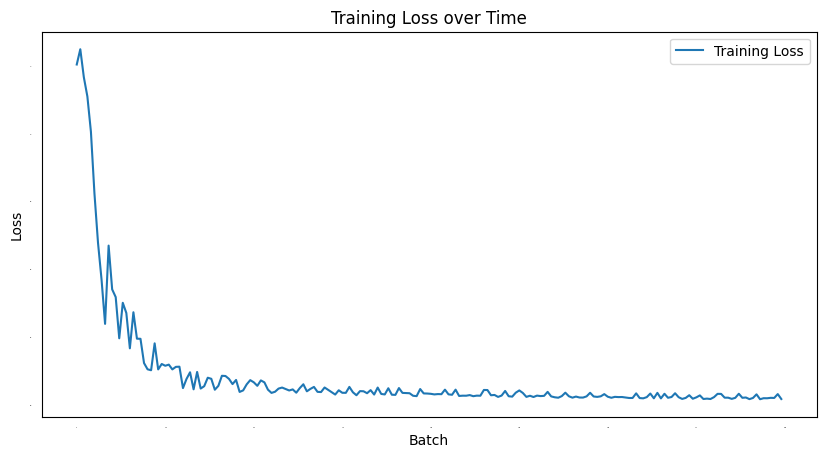

In [43]:
# Assuming train_images_np, gt_box_tensors, gt_classes_one_hot_tensors, train_image_tensors are already defined
losses=[]
for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]

    # Get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list, detection_model, optimizer, to_fine_tune)
    losses.append(total_loss.numpy())

    if idx % 10 == 0:
        print(f'batch {idx} of {num_batches}, loss={total_loss.numpy()}', flush=True)

print('Done fine-tuning!')

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.legend()
plt.show()

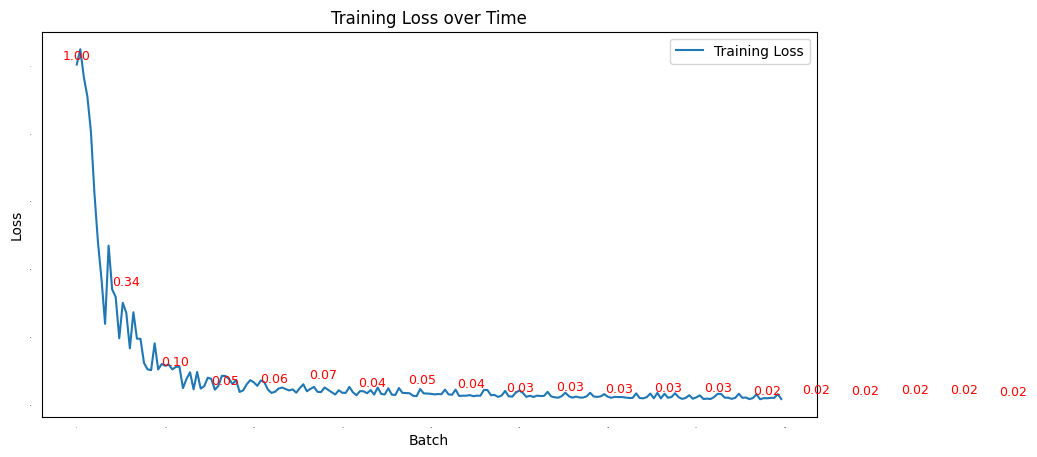

In [44]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')

# Annotate the graph with numeric indicators every 10 batches
for i in range(0, len(losses), 10):
    plt.annotate(f'{losses[i]:.2f}', xy=(i, losses[i]), xytext=(i, losses[i] + 0.5),
                 textcoords='offset points', ha='center', va='bottom', fontsize=9, color='red')

plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.legend()
plt.show()

In [45]:
#Load test images and run inference with new model!

import os
import zipfile
import numpy as np
import gdown
from PIL import Image

# Step 1: Uncomment if you want to delete existing files
!rm testing-cars.zip
!rm -rf ./test_car
!rm -rf ./results

# Step 2: Download the images
# Install gdown if not already installed
!pip install gdown
#https://drive.google.com/file/d/1GoOvnTqv0A5VyHw5ShsRfej3uMBV-pm4/view?usp=sharing
# Download the images from Google Drive
file_id = '1GoOvnTqv0A5VyHw5ShsRfej3uMBV-pm4'
output = './testing-cars.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

# Step 3: Unzip the downloaded file
local_zip = './testing-cars.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('./results')


rm: cannot remove 'testing-cars.zip': No such file or directory


Downloading...
From: https://drive.google.com/uc?id=1GoOvnTqv0A5VyHw5ShsRfej3uMBV-pm4
To: /content/testing-cars.zip
100%|██████████| 3.42M/3.42M [00:00<00:00, 129MB/s]


In [46]:
# List all files in the results directory
print(os.listdir('./results'))

['test_car000 (172).jpg', 'test_car000 (17).jpg', 'test_car000 (10).jpg', 'test_car000 (71).jpg', 'test_car000 (33).jpg', 'test_car000 (139).jpg', 'test_car000 (5).jpg', 'test_car000 (54).jpg', 'test_car000 (82).jpg', 'test_car000 (127).jpg', 'test_car000 (111).jpg', 'test_car000 (148).jpg', 'test_car000 (21).jpg', 'test_car000 (8).jpg', 'test_car000 (193).jpg', 'test_car000 (150).jpg', 'test_car000 (114).jpg', 'test_car000 (74).jpg', 'test_car000 (57).jpg', 'test_car000 (75).jpg', 'test_car000 (16).jpg', 'test_car000 (73).jpg', 'test_car000 (6).jpg', 'test_car000 (39).jpg', 'test_car000 (35).jpg', 'test_car000 (119).jpg', 'test_car000 (115).jpg', 'test_car000 (110).jpg', 'test_car000 (202).jpg', 'test_car000 (173).jpg', 'test_car000 (12).jpg', 'test_car000 (179).jpg', 'test_car000 (117).jpg', 'test_car000 (187).jpg', 'test_car000 (49).jpg', 'test_car000 (156).jpg', 'test_car000 (9).jpg', 'test_car000 (140).jpg', 'test_car000 (56).jpg', 'test_car000 (97).jpg', 'test_car000 (161).jpg', 

In [47]:
#oad these images into numpy arrays to prepare it for inference.
def load_image_into_numpy_array(image_path):
    """Load an image from file into a numpy array."""
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    # Resize while preserving channel dimension
    image_resized = image.resize((224, 224))
    return np.array(image_resized)

test_image_dir = './results/'
test_images_np = []

# Iterate through the expected image filenames and load them
for i in range(1, 205):  # Range adjusted to match the new filenames
    image_path = os.path.join(test_image_dir, f'test_car000 ({i}).jpg')
    if os.path.exists(image_path):
        try:
            print(f"Loading image: {image_path}")
            image_np = load_image_into_numpy_array(image_path)
            test_images_np.append(np.expand_dims(image_np, axis=0))
            # Moved tensor conversion after appending to list
            input_tensor = tf.convert_to_tensor(test_images_np[-1], dtype=tf.float32) # Access the last element
            # Debugging: Print the shape of the input tensor
            print(f"Input tensor shape: {input_tensor.shape}")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
    else:
        print(f"Image not found: {image_path}")

# Convert list to numpy array if not empty
if test_images_np:
    test_images_np = np.vstack(test_images_np)
    print(f"Loaded {len(test_images_np)} images.")
else:
    print("No images were loaded.")

Loading image: ./results/test_car000 (1).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image: ./results/test_car000 (2).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image: ./results/test_car000 (3).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image: ./results/test_car000 (4).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image: ./results/test_car000 (5).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image: ./results/test_car000 (6).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image: ./results/test_car000 (7).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image: ./results/test_car000 (8).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image: ./results/test_car000 (9).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image: ./results/test_car000 (10).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image: ./results/test_car000 (11).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image: ./results/test_car000 (12).jpg
Input tensor shape: (1, 224, 224, 3)
Loading image

In [48]:
# Access the last element of the array
input_tensor = tf.convert_to_tensor(test_images_np[-1], dtype=tf.float32)
# Debugging: Print the shape of the input tensor
print(f"Input tensor shape: {input_tensor.shape}")

Input tensor shape: (224, 224, 3)


In [49]:
#Preprocess, predict, and post process an image
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    # Ensure input tensor has a batch dimension
    if len(input_tensor.shape) == 3:
        input_tensor = tf.expand_dims(input_tensor, axis=0)

    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)

    ### START CODE HERE (Replace instances of `None` with your code) ###
    # use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict, shapes)
    ### END CODE HERE ###

    return detections

In [50]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    # Ensure the image has shape (height, width, 3)
    input_image = test_images_np[i]
    if len(input_image.shape) == 4:
        input_image = input_image[0]  # Remove the extra dimension if present

    input_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      input_image,  # Use the reshaped image
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [51]:
x = np.array(results['scores'])

# percent of frames where a car is detected
car_detected = (np.where(x > 0.9, 1, 0).sum())/204*100
print(car_detected)

12.745098039215685


Frame 0


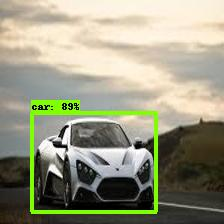


Frame 5


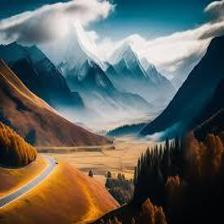


Frame 10


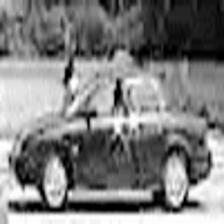

In [52]:
print('Frame 0')
display(IPyImage('./results/gif_frame_000.jpg'))
print()
print('Frame 5')
display(IPyImage('./results/gif_frame_004.jpg'))
print()
print('Frame 10')
display(IPyImage('./results/gif_frame_189.jpg'))

In [53]:
zipf = zipfile.ZipFile('./car_file.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()

In [54]:
import imageio
import glob
import os

# Download the freeimage plugin if not already downloaded
imageio.plugins.freeimage.download()

# Remove existing gif if it exists
if os.path.exists('./results/car-anim.gif'):
    os.remove('./results/car-anim.gif')

anim_file = './results/car-anim.gif'

# Collect filenames for frames
filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

images = []

# Read each frame image and append to the images list
for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

# Save images as an animated gif
imageio.mimsave(anim_file, images, format='GIF-FI', fps=10)

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


<ipython-input-54-e588a109ca53>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
